# HW3 - Coding Assignment

In order to get full marks, your result should include:

1. Your code.
2. Optimal $\mathsf{W}^*$ and $\mathbf{b}^*$. 
3. Training loss curve.
4. Plot of training data along with decision boundary.
5. Plot of test data along with decision boundary.
6. Test error.


## 7 (20 points) Softmax Classification

$\newcommand{\x}{{\bf x}}$**In Question 5**, we derived the derivative of cross-entropy loss with respect to each entry of $\mathsf{W}$ and $\mathbf{b}$ of each class. We now want to extend the expressions to vector form and implement them to accomplish a gradient descent training process.

Assume $\mathbf{p} = (p_0,..., p_{K-1})^T \in \mathbb{R}^K$, $\mathsf{W} = (\mathbf{w}_0, ..., \mathbf{w}_{K-1})^T \in \mathbb{R}^{K\times D}$ and $\mathbf{b} = (b_0,..., b_{K-1})^T \in \mathbb{R}^K$, the gradient of $\mathcal{L}_{\mathsf{xent}}(\x,y;\mathsf{W}, \mathbf{b})$ with respect to the $\mathsf{W}$ and $\mathbf{b}$ is given by:
$$\frac{\partial \mathcal{L}_{\mathsf{xent}}(\x,y;\mathsf{W}, \mathbf{b})}{\partial \mathsf{W}}=(\mathbf{p}-\mathbf{y})\mathbf{x}^T, \qquad
  \frac{\partial \mathcal{L}_{\mathsf{xent}}(\x,y;\mathsf{W}, \mathbf{b})}{\partial \mathbf{b}}=\mathbf{p}-\mathbf{y}$$
and the gradient of $\mathcal{L}(\mathsf{W}, \mathbf{b})$ with respect to the $\mathsf{W}$ and $\mathbf{b}$ is given by:
$$\frac{\partial \mathcal{L}(\mathsf{W}, \mathbf{b})}{\partial \mathsf{W}}=\sum_i (\mathbf{p}^{(i)}-\mathbf{y}^{(i)}){\mathbf{x}^{(i)}}^T, \qquad
  \frac{\partial \mathcal{L}(\mathsf{W}, \mathbf{b})}{\partial \mathbf{b}}=\sum_i (\mathbf{p}^{(i)}-\mathbf{y}^{(i)})$$
Furthermore, if we represent the training dataset in the matrix form: $\mathsf{X} = (\x^{(0)},..., \x^{(n-1)})^T \in \mathbb{R}^{n\times D}$,   $\mathsf{Y} = (\mathbf{y}^{(0)},..., \mathbf{y}^{(n-1)})^T \in \{0,1\}^{n\times K}$ and $\mathsf{P} = (\mathbf{p}^{(0)},..., \mathbf{p}^{(n-1)})^T \in \mathbb{R}^{n\times K}$. Thus, the gradient of $\mathcal{L}(\mathsf{W}, \mathbf{b})$ with respect to the $\mathsf{W}$ and $\mathbf{b}$ is given by:
$$\frac{\partial \mathcal{L}(\mathsf{W}, \mathbf{b})}{\partial \mathsf{W}}=(\mathsf{P}-\mathsf{Y})^T \mathsf{X}, \qquad
\frac{\partial \mathcal{L}(\mathsf{W}, \mathbf{b})}{\partial \mathbf{b}}=(\mathsf{P}-\mathsf{Y})^T \mathbf{1}$$
where $\mathbf{1} \in \mathbb{R}^n$ is a $n$-dim vector in which each entry is 1.

Complete the sections marked with "your code" in the skeleton codes below.

#### Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Load original Iris dataset.
iris = datasets.load_iris()
old_X = iris.data
old_Y = iris.target

# Create the modified Iris dataset.
new_X = old_X[:,2:]       # We only use last 2 features.
new_Y = old_Y.reshape(-1,1)

X_train =      np.vstack([new_X[:35],   new_X[50:85],  new_X[100:135]])
Y_train = np.concatenate([new_Y[:35],   new_Y[50:85],  new_Y[100:135]])
X_test  =      np.vstack([new_X[35:50], new_X[85:100], new_X[135:]])
Y_test  = np.concatenate([new_Y[35:50], new_Y[85:100], new_Y[135:]])

print(X_train.shape)     # X_train.shape should be (105,2), which shows 
                         # 150 training points where each has 2 features.
print(Y_train.shape)     # Y_train.shape should be (105,1) which shows 105 
print(np.unique(Y_train))# points where each point has label 0, 1 or 2.

(105, 2)
(105, 1)
[0 1 2]


#### Visualization of Original Data

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.utils import shuffle
import scipy.io as sio
plt.rcParams['figure.figsize'] = 8,8

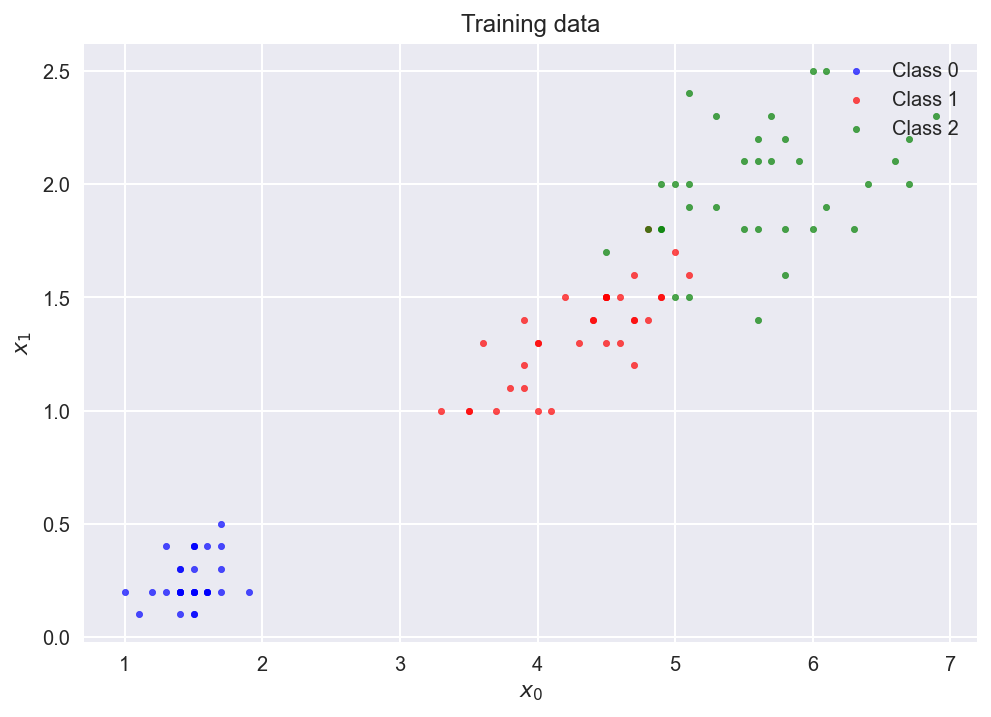

In [3]:
# Visualization of the training data.
mpl.style.use('seaborn')

fig = plt.figure()
plt.scatter(X_train[Y_train[:,0]==0, 0], 
            X_train[Y_train[:,0]==0, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_train[Y_train[:,0]==1, 0], 
            X_train[Y_train[:,0]==1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')
plt.scatter(X_train[Y_train[:,0]==2, 0], 
            X_train[Y_train[:,0]==2, 1], 
            marker='o', color='g', alpha=0.7, s=10, label='Class 2')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend(loc='upper right', fontsize=10)
plt.title('Training data')
plt.show()

#### Training Procedure

In [4]:
def softmax_P(X, W, b):
    """ Calculate the P (probability) matrix of softmax function.
    X: Feature matrix.   Shape: [n,D].
    W: Weight matrix.    Shape: [K,D].
    b: Bias vector.      Shape: [K,1].
    Return the P matrix. Shape: [n,K].
    """
    f         = W.dot(X.T) + b   # Shape: [K,n].
    f         = f - f.max(axis=0, keepdims=True)  # Avoid the big number 
    exp_f     = np.exp(f)        # Shape: [K,n].
    sum_exp_f = exp_f.sum(axis=0, keepdims=True)  # Shape: [1,n].
    P         = (exp_f / sum_exp_f).T
    return P

In [5]:
# Gradient of loss function: L'(W,b).
def L_prime(X, Y, W, b):
    """ L'(W,b) function. 
    X: Feature matrix. Shape: [n,D].
    Y: Label vector.   Shape: [n,1].
    W: Weight matrix.  Shape: [K,D].
    b: Bias vector.    Shape: [K,1].
    Return the gradients: dL/dW (Shape: [K,D]), dL/db (Shape: [K,1]).
    """
    # Get dimensions.
    K, D = W.shape
    n = X.shape[0]
    # Generate the one-hot encoding form of Y.
    
    ####### Begin your code ######
    # Y_onehot =                                     
    Y_onehot = []
    for i in Y:                                     # Shape: [n,K].
        if i == 0:
            Y_onehot.append([1,0,0])
        elif i == 1:
            Y_onehot.append([0,1,0])
        else:
            Y_onehot.append([0,0,1])
    Y_onehot = np.array(Y_onehot)
    
    ## Calculate the gradients: dL/dW, dL/db.
    ## Get the P matrix.
    P = softmax_P(X, W, b)                          # Shape: [n,K].
    dL_by_dW = (P - Y_onehot).T.dot(X)              # Shape: [K,D].
    dL_by_db = (P - Y_onehot)                       # Shape: [K,1].
    dL_by_db = dL_by_db[0]
    
    # Return the gradients.
    return dL_by_dW, dL_by_db

In [6]:
def L(X, Y, W, b):
    """ L(W,b) function. 
    X: Feature matrix. Shape: [n,D].
    Y: Label vector.   Shape: [n,1].
    W: Weight matrix.  Shape: [K,D].
    b: Bias vector.    Shape: [K,1].
    """
    # Get dimensions.
    K, D = W.shape
    n = X.shape[0]
    ####### Begin your code ######
    ## Generate the one-hot encoding form of Y.
    Y_onehot = []
    for i in Y:                                     # Shape: [n,K].
        if i == 0:
            Y_onehot.append([1,0,0])
        elif i == 1:
            Y_onehot.append([0,1,0])
        else:
            Y_onehot.append([0,0,1])
    Y_onehot = np.array(Y_onehot)

    ## Get the P matrix.
    P = softmax_P(X, W, b)                             # Shape: [n,K].
    L = -1 * Y_onehot.T.dot(np.log(P))                 # Shape: Scalar.                   
    L = L[0][0]
    
    return L

In [ ]:
learning_rate = 0.0025
n_iter = 100000       # Number of iterations
K = 3                 # Number of classes.
D = X_train.shape[1]  # Number of feature dimensions
W = np.zeros((K,D))   # Weight matrix.
b = np.zeros((K,1))   # Bias vector.

# We will keep track of training loss over iterations.
iterations = [0]
L_list = [L(X_train, Y_train, W, b)]
for i in range(n_iter):
    ####### Begin your code ######
    ## Calculate current gradients
    # gradient_W, gradient_b = 
    gradient_W, gradient_b = L_prime(X_train, Y_train, W, b)
    
    ## Perform gradient descent
    W_new = gradient_W
    b_new = 
    ####### End your code ########
    
    iterations.append(i+1)
    L_list.append(L(X_train, Y_train, W_new, b_new))
    norm = np.abs(W_new-W).sum() + np.abs(b_new-b).sum()  # L1-norm as jumping out criteria.
    if norm < 0.0005:
        print("Gradient descent has converged after " + str(i) + " iterations.")
        break
    W = W_new
    b = b_new
    
print ('W matrix: \n' + str(W))
print ('b vector: \n' + str(b))

#### Training Loss Curve

In [ ]:
plt.title('Training curve')
plt.xlabel('iteration')
plt.ylabel('L(W,b)')
plt.semilogy(iterations, np.array(L_list).reshape(-1, 1))
plt.show()

#### Results on Training Data

In [ ]:
# Prepare for decision boundary.
num = 100
X0_plane_range = np.linspace(1,7,num)
X1_plane_range = np.linspace(0,2.5,num)
X0_plane, X1_plane = np.meshgrid(X0_plane_range, X1_plane_range)
X_decision = np.stack([X0_plane.reshape(-1), X1_plane.reshape(-1)]).T
P_decision = softmax_P(X_decision, W, b) # Shape: [n,K].
yhat_decision = P_decision.argmax(axis=1).reshape(-1,1)

In [ ]:
# Training data points and decision boundary. 
plt.scatter(X_decision[yhat_decision[:,0]==0, 0], 
            X_decision[yhat_decision[:,0]==0, 1], 
            marker='o', color='b', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==1, 0], 
            X_decision[yhat_decision[:,0]==1, 1], 
            marker='o', color='r', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==2, 0], 
            X_decision[yhat_decision[:,0]==2, 1], 
            marker='o', color='g', alpha=0.1, s=10)

plt.scatter(X_train[Y_train[:,0]==0, 0],
            X_train[Y_train[:,0]==0, 1],
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_train[Y_train[:,0]==1, 0],
            X_train[Y_train[:,0]==1, 1],
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')
plt.scatter(X_train[Y_train[:,0]==2, 0],
            X_train[Y_train[:,0]==2, 1],
            marker='o', color='g', alpha=0.7, s=10, label='Class 2')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training data and decision boundary')

plt.legend(loc='lower right', fontsize=10)

#### Results on Test Data

In [ ]:
# Test data points and decision boundary. 
plt.scatter(X_decision[yhat_decision[:,0]==0, 0],
            X_decision[yhat_decision[:,0]==0, 1],
            marker='o', color='b', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==1, 0],
            X_decision[yhat_decision[:,0]==1, 1],
            marker='o', color='r', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==2, 0],
            X_decision[yhat_decision[:,0]==2, 1],
            marker='o', color='g', alpha=0.1, s=10)

plt.scatter(X_test[Y_test[:,0]==0, 0],
            X_test[Y_test[:,0]==0, 1],
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_test[Y_test[:,0]==1, 0],
            X_test[Y_test[:,0]==1, 1],
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')
plt.scatter(X_test[Y_test[:,0]==2, 0],
            X_test[Y_test[:,0]==2, 1],
            marker='o', color='g', alpha=0.7, s=10, label='Class 2')


plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training data and decision boundary')

plt.legend(loc='lower right', fontsize=10)

In [ ]:
# Calculate the test error.
P_test = softmax_P(X_test, W, b) # Shape: [n,K].
yhat_test = P_test.argmax(axis=1).reshape(-1,1)
test_error = 1 - np.sum(yhat_test == Y_test) / Y_test.shape[0]
print('Test error: {}'.format(test_error))

## 8 (Extra Credit - 25 points) Feed-forward Neural Network for Classification

In this section, we will use the feed-forward network defined in **Question 6**, which is as follows

\begin{align}
p(y|\mathbf{x})&=\sigma \Big(y \times \left(\mathbf{w}_2^T \left(\sigma (\mathsf{W}_1^T\mathbf{x}+\mathbf{b}_1)\right)+b_2\right)\Big),
\end{align}

where $\mathsf{W}_1\in\mathbb{R}^{2\times 3}$ and $\mathbf{w}_2\in\mathbb{R}^{3\times 1}$ are the weights, $\mathbf{b}_1 \in\mathbb{R}^{3\times 1}$ and $b_2 \in \mathbb{R}^{1\times 1}$ are the biases. The activation function is the logistic sigmoid function.


(You do **NOT** need to prove this sub-section, but understanding this sub-section can be beneficial to the programming part) Besides, in the gradient algorithm, we still need the $\frac{\partial \mathcal{L}}{\partial \mathsf{W}_1}$ and $\frac{\partial \mathcal{L}}{\partial \mathbf{b}_1}$, which have been given below ("$\circ$" means element-wise product):
1. $\displaystyle\frac{\partial \mathcal{L}} {\partial \mathsf{W}_1} = \mathbf{x}\bigg(\big(\frac{\partial \mathcal{L}}{\partial \mathbf{h}}\big)\circ \mathbf{h}\circ (1-\mathbf{h})\bigg)^T$.
2. $\displaystyle\frac{\partial \mathcal{L}} {\partial \mathbf{b}_1} = \big(\frac{\partial \mathcal{L}}{\partial \mathbf{h}}\big)\circ \mathbf{h}\circ (1-\mathbf{h})$.

Furthermore, assume $\mathsf{X} = (\mathbf{x}^{(0)}, ..., \mathbf{x}^{(n-1)})^T$, $\mathbf{y} = ({y}^{(0)}, ..., {y}^{(n-1)})^T$, $\mathsf{H} = (\mathbf{h}^{(0)}, ..., \mathbf{h}^{(n-1)})^T$, $\mathbf{p} = ({p}^{(0)}, ..., {p}^{(n-1)})^T$,  we can compute the $\frac{\partial \mathcal{L}_
\text{train}}{\partial \mathbf{w}_2}$, $\frac{\partial \mathcal{L}_
\text{train}}{\partial b_2}$, $\frac{\partial \mathcal{L}_\text{train}}{\partial \mathsf{H}}$, $\frac{\partial \mathcal{L}_
\text{train}}{\partial \mathsf{W}_1}$ and $\frac{\partial \mathcal{L}_\text{train}}{\partial \mathbf{b}_1}$ in a vectorized form (assume $\mathbf{1} \in \mathbb{R}^{n\times 1}$ is a $n$-dimenional vector where each entry is 1):

1. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial \mathbf{w}_2} = \mathsf{H}^T \big((
    \mathbf{p}-\mathbf{1})\circ\mathbf{y}\big)$.
2. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial {b}_2} = \mathbf{1}^T\big((
    \mathbf{p}-\mathbf{1})\circ\mathbf{y}\big) $.
3. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial \mathsf{H}} = \big((
    \mathbf{p}-\mathbf{1})\circ\mathbf{y}\big) \mathbf{w}_2^T$ .
4. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial \mathsf{W}_1} = \mathsf{X}^T\bigg(\big(\frac{\partial \mathcal{L}_\text{train}}{\partial \mathsf{H}}\big)\circ \mathsf{H}\circ (1-\mathsf{H})\bigg)$.
5. $\displaystyle\frac{\partial \mathcal{L}_\text{train}} {\partial 
    \mathbf{b}_1} = \bigg(\big(\frac{\partial \mathcal{L}_\text{train}}{\partial \mathsf{H}}\big)\circ \mathsf{H}\circ (1-\mathsf{H})\bigg)^T \mathbf{1}$.


Complete the sections marked with "your code" in the skeleton codes below.

#### Load Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Load original Iris dataset.
iris = datasets.load_iris()
old_X = iris.data
old_Y = iris.target

# Create the modified Iris dataset.
new_X = old_X[old_Y>0][:,2:]            # We only use last 2 features.
new_Y = old_Y[old_Y>0].reshape(-1,1)    # Use class 1,2 and convert 
new_Y[new_Y==1] = -1                    # them into class -1,1.
new_Y[new_Y==2] = 1        

# Generate training set and test set.
X_train =      np.vstack([new_X[:35],   new_X[50:85]])  # Shape: [70,2].
Y_train = np.concatenate([new_Y[:35],   new_Y[50:85]])  # Shape: [70,1].
X_test  =      np.vstack([new_X[35:50], new_X[85:100]]) # Shape: [30,2].
Y_test  = np.concatenate([new_Y[35:50], new_Y[85:100]]) # Shape: [30,1].

print(X_train.shape)     # X_train.shape should be (70,2), which shows 
                         # 70 training points where each has 2 features.
print(Y_train.shape)     # Y_train.shape should be (70,1) which shows 70 
print(np.unique(Y_train))# points where each point has label -1, 1.

#### Visualization of Original Data

In [ ]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import math
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from sklearn.utils import shuffle
import scipy.io as sio
plt.rcParams['figure.figsize'] = 8,8

In [ ]:
# Visualization of the training data.
mpl.style.use('seaborn')

fig = plt.figure()
plt.scatter(X_train[Y_train[:,0]==-1, 0], 
            X_train[Y_train[:,0]==-1, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_train[Y_train[:,0]==+1, 0], 
            X_train[Y_train[:,0]==+1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend(loc='upper right', fontsize=10)
plt.title('Training data')
plt.show()

#### Training Procedure

In [ ]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

In [ ]:
# Gradient of loss function: L'(W1, b1, W2, b2).
def L_prime(X, Y, W1, b1, W2, b2):
    """ L'(W,b) function. 
    X:  Feature matrix.    Shape: [n,2].
    Y:  Label vector.      Shape: [n,1].
    W1: Weight matrix W1.  Shape: [2,3].
    b1: Bias vector b1.    Shape: [3,1].
    W2: Weight matrix W2.  Shape: [3,1].
    b2: Bias vector b2.    Shape: [1,1].
    Return the gradients: dL/dW1 (Shape: [2,3]), dL/db1 (Shape: [3,1]),
                          dL/dW2 (Shape: [3,1]), dL/db2 (Shape: [1,1]).
    """
    # Get dimensions.
    n = X.shape[0]
    
    ####### Begin your code ######
    ## Calculate feed-forward values.
    # H =                             # Shape: [n, 3].
    # P =                             # Shape: [n, 1].
    
    ## Calculate the gradients: dL/dW1, dL/db1, dL/dW2, dL/db2.
    # dL_by_dW2 =                              # Shape: [3,1].
    # dL_by_db2 =                              # Shape: [1,1].
    # dL_by_dH  =                              # Shape: [n,3].
    
    # dL_by_dW1  =                             # Shape: [2,3].
    # dL_by_db1  =                             # Shape: [3,1].
    ####### End your code ########
    
    # Return the gradients.
    return dL_by_dW1, dL_by_db1, dL_by_dW2, dL_by_db2

In [ ]:
def L(X, Y, W1, b1, W2, b2):
    """ L(W,b) function. 
    X:  Feature matrix.    Shape: [n,2].
    Y:  Label vector.      Shape: [n,1].
    W1: Weight matrix W1.  Shape: [2,3].
    b1: Bias vector b1.    Shape: [3,1].
    W2: Weight matrix W2.  Shape: [3,1].
    b2: Bias vector b2.    Shape: [1,1].
    Return the loss.       Shape: Scalar.
    """
    # Get dimensions.
    n = X.shape[0]
    
    ####### Begin your code ######
    ## Calculate feed-forward values.
    # H =                             # Shape: [n, 3].
    # P =                             # Shape: [n, 1].
    
    ## Get the loss.
    # L =                             # Shape: Scalar.
    
    ####### End your code ########
    
    return L

In [ ]:
## The following codes might take a while to run, please be patient

learning_rate = 0.0025
n_iter = 200000                        # Number of iterations
np.random.seed(0)
W1 = np.random.randn(2,3)/((2*3)**2)   # Weight matrix 1.
b1 = np.random.randn(3,1)/((3*1)**2)   # Bias vector 1.
W2 = np.random.randn(3,1)/((3*1)**2)   # Weight matrix 2.
b2 = np.random.randn(1,1)/((1*1)**2)   # Bias vector 2.

# We will keep track of training loss over iterations.
iterations = [0]
L_list = [L(X_train, Y_train, W1, b1, W2, b2)]
for i in range(n_iter):
    ####### Begin your code ######
    ## Calculate current gradients
    # gradient_W1, gradient_b1, gradient_W2, gradient_b2 = 
    ## Perform gradient descent
    # W1_new = 
    # b1_new = 
    # W2_new = 
    # b2_new = 
    ####### End your code ########
    
    iterations.append(i+1)
    L_list.append(L(X_train, Y_train, W1_new, b1_new, W2_new, b2_new))
    
    # L1-norm of weight/bias changing.
    norm = np.abs(W1_new-W1).sum() + np.abs(b1_new-b1).sum() + \
           np.abs(W2_new-W2).sum() + np.abs(b2_new-b2).sum() 
    
    if i%40000 == 0 or i+1 == n_iter:
        print('i: {:6d} L: {:.3f} norm:{:.6f}'.format(i, L_list[-1], norm))
        
    W1 = W1_new
    b1 = b1_new
    W2 = W2_new
    b2 = b2_new
    
print ('W1 matrix: \n' + str(W1))
print ('b1 vector: \n' + str(b1))
print ('W2 matrix: \n' + str(W2))
print ('b2 vector: \n' + str(b2))

#### Training Loss Curve

In [ ]:
plt.title('Training curve')
plt.xlabel('iteration')
plt.ylabel('L(W,b)')
plt.semilogy(iterations, np.array(L_list).reshape(-1, 1))
plt.show()

#### Results on Training Data

In [ ]:
# Prepare for decision boundary.
num = 100
X0_plane_range = np.linspace(1,7,num)
X1_plane_range = np.linspace(0,2.5,num)
X0_plane, X1_plane = np.meshgrid(X0_plane_range, X1_plane_range)
X_decision = np.stack([X0_plane.reshape(-1), X1_plane.reshape(-1)]).T

# Calculate feed-forward values.
f_decision = sigmoid(X_decision.dot(W1)+b1.T).dot(W2)+b2.T # Shape: [n,1].
yhat_decision = np.sign(f_decision)

In [ ]:
# Training data points and decision boundary. 
plt.scatter(X_decision[yhat_decision[:,0]==-1, 0], 
            X_decision[yhat_decision[:,0]==-1, 1], 
            marker='o', color='b', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==1, 0], 
            X_decision[yhat_decision[:,0]==1, 1], 
            marker='o', color='r', alpha=0.1, s=10)

plt.scatter(X_train[Y_train[:,0]==-1, 0], 
            X_train[Y_train[:,0]==-1, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_train[Y_train[:,0]==1, 0], 
            X_train[Y_train[:,0]==1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training data and decision boundary')

plt.legend(loc='lower right', fontsize=10)

#### Results on Test Data

In [ ]:
# Test data points and decision boundary. 
plt.scatter(X_decision[yhat_decision[:,0]==-1, 0], 
            X_decision[yhat_decision[:,0]==-1, 1], 
            marker='o', color='b', alpha=0.1, s=10)
plt.scatter(X_decision[yhat_decision[:,0]==1, 0], 
            X_decision[yhat_decision[:,0]==1, 1], 
            marker='o', color='r', alpha=0.1, s=10)

plt.scatter(X_test[Y_test[:,0]==-1, 0], 
            X_test[Y_test[:,0]==-1, 1], 
            marker='o', color='b', alpha=0.7, s=10, label='Class 0')
plt.scatter(X_test[Y_test[:,0]==1, 0], 
            X_test[Y_test[:,0]==1, 1], 
            marker='o', color='r', alpha=0.7, s=10, label='Class 1')

plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training data and decision boundary')

plt.legend(loc='lower right', fontsize=10)

In [ ]:
# Calculate the test error.
f_test = sigmoid(X_test.dot(W1)+b1.T).dot(W2)+b2.T  # Shape: [n,1].
yhat_test = np.sign(f_test)
test_error = 1 - np.sum(yhat_test == Y_test) / Y_test.shape[0]
print('Test error: {}'.format(test_error))